# Work starting on January 19th: Part 1

1. Just have the defocus (and no aberration) <br>
    a. How does the performance vary with number of iterations? <br>
    b. How does the performance vary with learning rate? <br>
    c. How does the performance vary with loss multiplier? <br>
    d. How does the performance vary with optimizer?
        i. Research what SGD and Adam optimizers are.
        ii. What are the benefits of Adam over SGD? In what cases are which more or less appropriate?
    e. How does the performance vary with different starting values of defocus? <br>
        i. Research what is typical uncertainty in the defocus value.

2. Just take one aberration (spherical aberration) into account. Repeat above steps. <br>
   Also track what happens to the aberration values- should tend towards the GT (0).

3. Add some noise to the reference image. <br>
    Generate image and add noise using the Demos/HRTEM.py program.

4. Simulate a molecule instead of a crystal. <br>
    
While examining, collect the resultant images.    

While examining, look at the gradients.
The gradient if starting at a defocus of 200 (the ground truth) should be zero.

In [4]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline

#crystal = pyms.structure.fromfile(
#    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
#)

crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [5]:
# Establish aberrations
# Just defocus for now

def establish_aberrations():
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = 175.0

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    
    return aberrations


In [6]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    #plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)
    
    return output

In [31]:
def save_sim_image(sim_image, n_iter):
    plt.imshow(sim_image[0].detach().cpu().numpy())

    plt.title(u'Simulated image of SrTiO\u2083\n after {n} iterations'.format(n=n_iter), fontsize=15)
    plt.xticks([])
    plt.yticks([])

    filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/simulated_image_"+ str(n_iter) + ".jpg"
    plt.savefig(filepath, dpi=500)
    print("Saved")

In [28]:
def optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([])

    optimizer = torch.optim.Adam(params, lr = learning_rate)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    # SHIT, should save the simulated image as we run this
    # FUCK
    save_sim_image(sim_image, n_iters)
    
    return runtime, loss.item(), aberrations[0].amplitude.item()

    #print("Time to run:", str((end - start)))
    #print("Loss", str(loss.item())) # Final loss value
    #print("Final defocus value", str(aberrations[0].amplitude.item()))

In [8]:
def main(n_iters, learning_rate, loss_multiplier):
    aberrations = establish_aberrations()
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final = optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier)
    return runtime, loss, defocus_final
    
    

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved


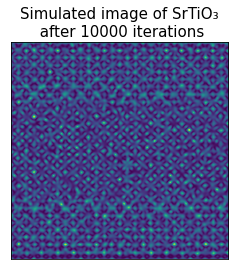

In [33]:
n_iterations = [10, 100, 1000, 2000, 5000, 10000]

# Constants
learning_rate = 1e-1
loss_multiplier = 1e9

runtimes = []
losses = []
defocus_values = []

for i in n_iterations:
    runtime, loss, defocus_final = main(i, learning_rate, loss_multiplier)
    runtimes.append(runtime)
    losses.append(loss)
    defocus_values.append(defocus_final)


I want to save this data somewhere so I don't have to rerun stuff to get the data.

In [38]:
# Saving data to file code

filename = "Variation_iterations.txt"

f = open(filename, "w")
x = "Number of Iterations, Loss, Final defocus value, time to run"
f.write(x)
f.write("\n")

for i in range(0, len(n_iterations)):
    line = str(n_iterations[i]) +  ", " + str(losses[i]) + ", " + str(defocus_values[i]) + ", " + str(runtimes[i])
    f.write(line)
    f.write("\n")

f.close() 

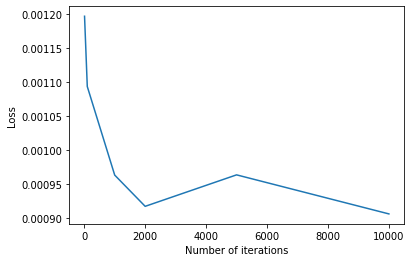

In [39]:
plt.plot(n_iterations, losses)
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Loss.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

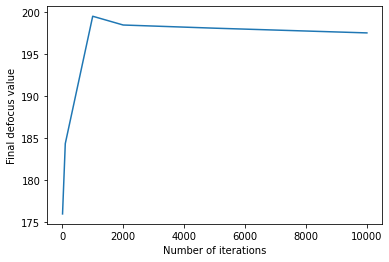

In [40]:
plt.plot(n_iterations, defocus_values)
plt.ylabel('Final defocus value')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Defocus.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

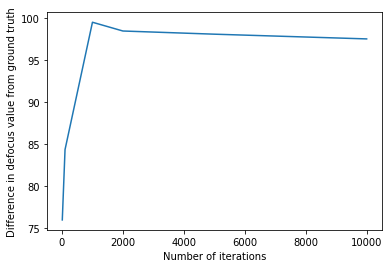

In [41]:
y_data = [x-100 for x in defocus_values]

plt.plot(n_iterations, y_data)
plt.ylabel('Difference in defocus value from ground truth')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Defocus-change.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

### Starting Image

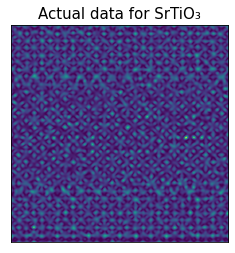

In [21]:
path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'

ref_data = np.load(path)
ref_data = torch.tensor(ref_data).to('cpu') # change cuda to cpu

plt.imshow(torch.abs(ref_data).numpy()) # removed .cpu and .detach and vmax=10 (vmax was the thing causing issues)

plt.title(u'Actual data for SrTiO\u2083', fontsize=15)
plt.xticks([])
plt.yticks([])

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/actual_data_image.jpg"
plt.savefig(filepath, dpi=500)